# Predicting Alphabet and Character

Data source: 
- Training: `data-sources/omniglot/omniglot_train/`
- Testing : `data-sources/omniglot/omniglot_test/`

Predicting: 
- alphabet (30 different alphabets)
- character (964 different characters)

## 1. Prepare environment

In [1]:
# Importing libraries
import expectexception
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re

import torch
import torch.nn as nn
import torch.optim as optim

from environment import prepare_environment
from PIL import Image
from typing import List, Tuple
from sklearn.preprocessing import LabelBinarizer
from pprint import pprint

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchmetrics import Accuracy

In [2]:
# Global variables
SEED = 42

DATASET_OMNIGLOT_TRAIN = "data-sources/omniglot/omniglot_train/"
DATASET_OMNIGLOT_TEST = "data-sources/omniglot/omniglot_test/"

MODEL_OMNIGLOT_CLASSIFIER = "artifacts/omniglotclassifier-multioutput.pth"

In [3]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
print(torch.__version__)
print('Cuda is available?', torch.cuda.is_available())

device = torch.cuda.current_device()  # returns you the ID of your current device
print('Device:', torch.cuda.get_device_name(device))  # returns you the name of the device

# # Reviewing allocated memmory, it is 0 if there is nothing allocated
# cuda_memory = torch.cuda.memory_allocated(device)
# cuda_cache = torch.cuda.memory_reserved(device)
# print(f"""
# CUDA memory device: {cuda_memory}
# CUDA cache  device: {cuda_cache}
# """)

2.4.1+cu124
Cuda is available? True
Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [4]:
# Global configuration
prepare_environment()

torch.set_printoptions(precision=10)

# Reproducibility
np.random.seed(SEED)
_ = torch.manual_seed(SEED)

### Utilities

In [5]:
class OmniglotDataset(Dataset):
    """Extended DatasetClass to generate a 2-input Dataset.
    Assumptions:
    - The images are distributed by alphabets and characters subfolders, each alphabets contains n subfolders one for
      each characters, and inside there is n images.
    """
    def __init__(self, 
                 transform: transforms.transforms.Compose, 
                 samples: List[Tuple[str, np.ndarray, int]]) -> None:
        self.transform = transform
        self.samples = samples
    
    def __len__(self) -> int:
        return len(self.samples)
        
    def __getitem__(self, idx) -> Tuple[Image.Image, np.ndarray, int]:
        img_path, alphabet, label = self.samples[idx]
        img = Image.open(img_path).convert('L')  # L >> Grayscale
        img = self.transform(img)
        return img, alphabet, label

In [6]:
def get_samples(root_dir: str) -> List[Tuple[str, np.ndarray, int]]:
    """Get samples to use in the Two-Input-Dataset."""
    samples = []
    alphabet_dict = {}
    char_pos = -1
    prev_alphabet = ''
    for path, root, files in os.walk(root_dir):
        if not alphabet_dict:
            alphabet_dict = root
        if files:
            if files[0][-3:] == 'png':
                path_items = path.replace('\\', '/').split('/')
                alphabet_name = path_items[-2]
                if alphabet_name != prev_alphabet:
                    if prev_alphabet != '':
                        char_pos = char_num
                    prev_alphabet = alphabet_name
                alphabet = alphabet_dict.index(alphabet_name)
                char_num = int(re.search(r'\d{0,3}$', path_items[-1]).group()) + char_pos
                samples.extend([(os.path.join(path, file), alphabet, char_num)
                                for file in files])
    return samples

In [7]:
class TwoOutputNetModel(nn.Module):
    """Two-Output Architecture Model to predict the character and 
    the alphabet it belongs to.
    """
    def __init__(self):
        super().__init__()
        self.image_layer = nn.Sequential(         # Input img 1X64x64 (channel, w, h)
            nn.Conv2d(1, 16, 
                      kernel_size=3, padding=1),  # In-channel=1, Out-channel=16 → 16x64x64
            nn.MaxPool2d(kernel_size=2),          # Divide image size by 2 → 16x32x32
            nn.ELU(),                             # No Changes → 16x32x32
            nn.Flatten(),                         # Flatten → 16x32x32
            nn.Linear(16*32*32, 128),             # No Changes → 16x32x32
        )
        self.classifier_alpha = nn.Linear(128, 30)
        self.classifier_char = nn.Linear(128, 964)

    def forward(self, x_image:torch.Tensor):
        x_image = x_image.float()
        x_image = self.image_layer(x_image)
        output_alpha = self.classifier_alpha(x_image)
        output_char = self.classifier_char(x_image)
        return output_alpha, output_char

## 2. Review datasets

In [8]:
print('TRAIN DATASET:')
total_img = 0
total_chr = 0
for directory in os.listdir(DATASET_OMNIGLOT_TRAIN):
    char_files = [(len(d), len(f)) 
                  for _, d, f in os.walk(DATASET_OMNIGLOT_TRAIN + directory)]
    num_chars, num_files = map(sum, zip(*char_files))
    print(f'- {directory:<42} >> chars: {num_chars}, images: {num_files}')
    total_img += num_files
    total_chr += num_chars
print(f'Total images: {total_img} ({total_chr} characters)')

TRAIN DATASET:
- Alphabet_of_the_Magi                       >> chars: 20, images: 301
- Anglo-Saxon_Futhorc                        >> chars: 29, images: 438
- Arcadian                                   >> chars: 26, images: 398
- Armenian                                   >> chars: 41, images: 620
- Asomtavruli_(Georgian)                     >> chars: 40, images: 575
- Balinese                                   >> chars: 24, images: 369
- Bengali                                    >> chars: 46, images: 680
- Blackfoot_(Canadian_Aboriginal_Syllabics)  >> chars: 14, images: 205
- Braille                                    >> chars: 26, images: 397
- Burmese_(Myanmar)                          >> chars: 34, images: 511
- Cyrillic                                   >> chars: 33, images: 482
- Early_Aramaic                              >> chars: 22, images: 338
- Futurama                                   >> chars: 26, images: 400
- Grantha                                    >> chars: 43, ima

In [9]:
print('TEST DATASET:')
total_img = 0
total_chr = 0
for directory in os.listdir(DATASET_OMNIGLOT_TEST):
    char_files = [(len(d), len(f)) 
                  for _, d, f in os.walk(DATASET_OMNIGLOT_TEST + directory)]
    num_chars, num_files = map(sum, zip(*char_files))
    print(f'- {directory:<42} >> chars: {num_chars}, images: {num_files}')
    total_img += num_files
    total_chr += num_chars
print(f'Total images: {total_img} ({total_chr} characters)')

TEST DATASET:
- Alphabet_of_the_Magi                       >> chars: 20, images: 244
- Anglo-Saxon_Futhorc                        >> chars: 29, images: 351
- Arcadian                                   >> chars: 26, images: 328
- Armenian                                   >> chars: 41, images: 537
- Asomtavruli_(Georgian)                     >> chars: 40, images: 510
- Balinese                                   >> chars: 24, images: 302
- Bengali                                    >> chars: 46, images: 594
- Blackfoot_(Canadian_Aboriginal_Syllabics)  >> chars: 14, images: 175
- Braille                                    >> chars: 26, images: 302
- Burmese_(Myanmar)                          >> chars: 34, images: 429
- Cyrillic                                   >> chars: 33, images: 410
- Early_Aramaic                              >> chars: 22, images: 282
- Futurama                                   >> chars: 26, images: 321
- Grantha                                    >> chars: 43, imag

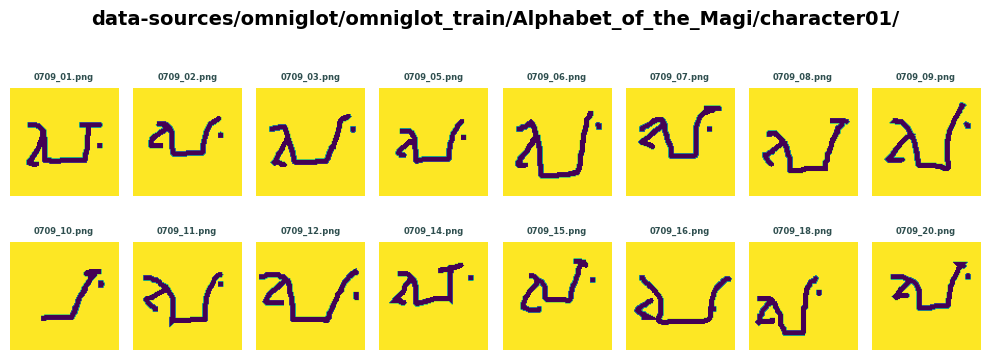

In [10]:
# Reviewing kind of images
image_dir = DATASET_OMNIGLOT_TRAIN + os.listdir(DATASET_OMNIGLOT_TRAIN)[0]
image_dir = image_dir + '/' + os.listdir(image_dir)[0] + '/'
images = os.listdir(image_dir)

fig, axes =  plt.subplots(2, int(len(images)/2), figsize=(10, 4))
fig.suptitle(image_dir)
axes = axes.flatten()
for i, ax in enumerate(axes):
    image = plt.imread(f"{image_dir}{images[i]}")
    ax.imshow(image)
    ax.set_title(images[i], fontsize=6)
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Get dataloader

In [11]:
# Get the samples
samples_train = get_samples(DATASET_OMNIGLOT_TRAIN)
samples_test = get_samples(DATASET_OMNIGLOT_TEST)

# Image transformation
image_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((64, 64)),
                                      ])

# Get the dataset
dataset_train = OmniglotDataset(transform=image_transforms, samples=samples_train)
dataset_test = OmniglotDataset(transform=image_transforms, samples=samples_test)

print(f"""
Train dataset size: {len(dataset_train)}
Test dataset size: {len(dataset_test)}
""")

# Create a DataLoader based on dataset
dataloader_train = DataLoader(dataset_train, batch_size=20, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=20, shuffle=True)


Train dataset size: 14400
Test dataset size: 12149



Data point: torch.Size([1, 64, 64])
Image reshaped torch.Size([64, 64, 1])


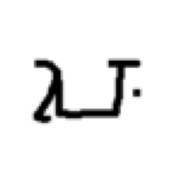

In [12]:
# reviewing the dataset
image, alphabet, label = dataset_train[0]
print("Data point:", image.shape)

image = image.permute(1, 2, 0)
print("Image reshaped", image.shape)

fig = plt.figure(figsize=(2, 2))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

## 4. Build the model

In [13]:
# Build the model
model = TwoOutputNetModel()
print(f"Are we using GPU? {next(model.parameters()).is_cuda}\n")
print(model)

# Set the criterion and teh optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # weight_decay=1e-4

Are we using GPU? False

TwoOutputNetModel(
  (image_layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ELU(alpha=1.0)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=16384, out_features=128, bias=True)
  )
  (classifier_alpha): Linear(in_features=128, out_features=30, bias=True)
  (classifier_char): Linear(in_features=128, out_features=964, bias=True)
)


## 5. Train the model

In [14]:
# Train the model
losses = []
epochs = 10

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    
    for img, label_alpha, label_char in dataloader_train:
        optimizer.zero_grad()                       # zero the parameter gradients
        output_alpha, output_char = model(img)      # Run a forward pass
        loss_alpha = criterion(output_alpha, label_alpha)
        loss_char = criterion(output_char, label_char)
        loss = loss_alpha + loss_char               # Compute loss
        loss.backward()                             # Backward pass
        optimizer.step()                            # Optimization
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    losses.append(epoch_loss)                       # Record the loss per epoch
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.6f}")

Epoch 1, Loss: 9.346181
Epoch 2, Loss: 6.282943
Epoch 3, Loss: 4.934506
Epoch 4, Loss: 3.974163
Epoch 5, Loss: 3.146432
Epoch 6, Loss: 2.501851
Epoch 7, Loss: 2.042463
Epoch 8, Loss: 1.741775
Epoch 9, Loss: 1.531905
Epoch 10, Loss: 1.352685


In [15]:
print(f"""
label_alpha: {label_alpha.shape}
{label_alpha}

output_alpha (first 1 rows): {output_alpha.shape}
{output_alpha[:1]}


label_char: {label_char.shape}
{label_char}

output_char: {output_char.shape}
{output_char}
""")


label_alpha: torch.Size([20])
tensor([ 6, 19, 13, 20, 20, 19, 23,  1, 26, 10, 11,  4, 16, 18,  0, 24,  8,  6,
        13, 23])

output_alpha (first 1 rows): torch.Size([20, 30])
tensor([[ -1.6985266209,  -4.3665766716,  -4.1631860733,   1.0867537260,
           1.7051668167,  -2.7649734020,   8.2407960892,   0.5403601527,
         -10.4737892151,  -1.2988927364,   4.8944277763,   3.7626376152,
          -3.6137814522,  -7.3960733414,  -0.5034580827,  -3.0483283997,
           4.6389164925,  -4.7463774681,   0.0175875649,  -2.9426589012,
           2.1288249493,   2.3561484814,  -8.0451488495,  -0.4117048681,
           3.8036758900,  -3.2443876266,   5.9659333229,  -6.9022331238,
          -5.8318219185,   0.7081262469]], grad_fn=<SliceBackward0>)


label_char: torch.Size([20])
tensor([218, 591, 407, 668, 664, 623, 745,  33, 835, 322, 338, 148, 509, 546,
          6, 805, 258, 205, 417, 776])

output_char: torch.Size([20, 964])
tensor([[ -5.1659345627,  -6.2321515083,  -2.5171413422, 

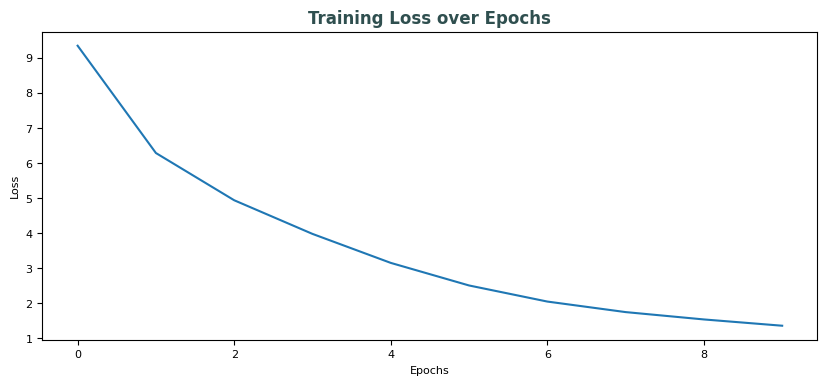

In [16]:
# Visualizing the loss in training set
fig = plt.figure(figsize=(10, 4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [17]:
# Saving the model
torch.save(model, MODEL_OMNIGLOT_CLASSIFIER)

## 6. Evaluate model

In [18]:
# Set the evaluation metrics
metric_acc_alpha = Accuracy(task="multiclass", num_classes=30)
metric_acc_char = Accuracy(task="multiclass", num_classes=964)

# Evaluation loop
model.eval()
with torch.no_grad():
    for img, label_alpha, label_char in dataloader_test:
        out_alpha, out_char = model(img)
        _, pred_alpha = torch.max(out_alpha, 1)
        _, pred_char = torch.max(out_char, 1)
        metric_acc_alpha(pred_alpha, label_alpha)
        metric_acc_char(pred_char, label_char)

# Compute metrics
print(f"Alphabet: {metric_acc_alpha.compute()}")
print(f"Character: {metric_acc_char.compute()}")

Alphabet: 0.5877026915550232
Character: 0.7230224609375


In [19]:
pd.DataFrame({
    'Alphabet': label_alpha.numpy(),
    'Prediction': pred_alpha.numpy(),
    'Accerted': ['True' 
                 if label_alpha.numpy()[i] == pred_alpha.numpy()[i]
                 else ''
                 for i in range(len(label_alpha))] 
})

,Alphabet,Prediction,Accerted
0,12,12,True
1,13,13,True
2,10,15,
3,2,2,True
4,10,10,True
5,2,15,
6,15,2,
7,28,28,True
8,10,29,


In [20]:
pd.DataFrame({
    'Character': label_char.numpy(),
    'Prediction': pred_char.numpy(),
    'Accerted': ['True' 
                 if label_char.numpy()[i] == pred_char.numpy()[i]
                 else ''
                 for i in range(len(label_char))] 
})

,Character,Prediction,Accerted
0,379,934,
1,415,415,True
2,305,305,True
3,60,60,True
4,312,312,True
5,74,74,True
6,483,483,True
7,901,901,True
8,301,301,True


## 7. Close environment

In [21]:
# Reviewing allocated memmory, it is 0 if there is nothing allocated
cuda_memory = torch.cuda.memory_allocated(device)
cuda_cache = torch.cuda.memory_reserved(device)
print(f"""
CUDA memory device: {cuda_memory}
CUDA cache  device: {cuda_cache}
""")

# Free allocated memory
torch.cuda.empty_cache() 


CUDA memory device: 0
CUDA cache  device: 0



----------------------------------